# Машинное обучение, ФКН ВШЭ

## Практическое задание (Бонус). Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 23:59MSK 24.12.2023

Жесткий дедлайн: 23:59MSK 24.12.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 6 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [392]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [393]:
# from sklearn.datasets import load_boston

In [394]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

### Код взял из чата


In [395]:
# X = boston["data"]
# y = boston["target"]

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [396]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.424944573624934

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (1.5 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [397]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

def compute_biase_variance(regressor, X, y, num_runs=100):

    np.random.seed(52)

    all_preds = pd.DataFrame()


    for i in range(num_runs):


        indx_train = np.random.choice(np.arange(X.shape[0]), X.shape[0])

        indx_test = np.setdiff1d(np.arange(X.shape[0]), indx_train)

        X_tr, y_tr = X[indx_train], y[indx_train]

        X_tst, y_tst = X[indx_test], y[indx_test]

        regressor.fit(X_tr, y_tr)

        prediction = regressor.predict(X_tst).reshape(-1,1)

        new_data = pd.DataFrame(prediction, indx_test).reset_index().rename(columns={'index': 'id', 0:'pred'})

        new_data = pd.concat([new_data, pd.DataFrame(y_tst)], axis=1).rename(columns={0:'Y | X'})

        all_preds = pd.concat([all_preds, new_data])

    ### bias ###

    perm_data = all_preds.groupby('id').agg({'pred':'mean'}).reset_index().rename(columns={'pred':'mu(Y | X)'})

    all_data = pd.merge(all_preds, perm_data, on='id')
    
    all_data['square'] = (all_data['Y | X'] - all_data['mu(Y | X)'])**2

    bias = all_data.square.mean()
    

    ### variance ###

    all_data['variance'] = (all_data['pred'] - all_data['mu(Y | X)']) ** 2
    var = all_data.variance.mean() 


    ### Loss ###

    all_data['loss'] = (all_data['pred'] - all_data['Y | X']) ** 2
    Loss = all_data.loss.mean()

    return (Loss, var, bias)    

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [398]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

linreg = LinearRegression()
decisTree = DecisionTreeRegressor()
random_forest = RandomForestRegressor()

lreg = compute_biase_variance(linreg, X, y)
dtree = compute_biase_variance(decisTree, X, y)
rf = compute_biase_variance(random_forest, X, y)

answer = pd.DataFrame()

for i, j in zip([lreg, dtree, rf], ['LinearRegression', 'DecisionTree', 'RandomForest']):

    new_data = pd.DataFrame([[j, i[0], i[1], i[2]]]).rename(columns={0:'Model', 1:'Loss', 2:'Variance', 3:'Bias'})
    answer = pd.concat([answer, new_data])

answer.set_index('Model')

,Loss,Variance,Bias
Model,,,
LinearRegression,24.348771,0.918046,23.430725
DecisionTree,23.003967,12.462878,10.541090
RandomForest,13.019708,2.333117,10.686591


__3. (0.5 баллов)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

> ## <div style='color:red'>Линейная регрессия</div>
>
> #### В теории модели линейной регрессии обладают большим смещением, так как связи между объектами могут быть нелинейными и в целом использование линейной регрессии может плохо описывать истинные взаимосвязи. Однако и разброс алгоритма должен быть маленьким, поскольку при изменении обучающей выборки сам вид прямой будет слабо меняться. Это видно и на результатах разложения ошибки на смещение и разброс: смещение занимает большую часть ошибки, что связано с плохой обобщающей способностью линейной регрессии, однако и разброс очень маленький, так как семплирование исходной выборки не сильно меняет оценки весов $\Rightarrow$ и разброс маленький
>
>  ## <div style='color:red'>Решающее дерево</div>
>
> #### Известным фактом является, что построение дерева очень сильно зависит от обучающих данных: при изменении обучающей выборки могут построиться абсолютно другие разбиения, таким образом видоизменяя само дерево. На данных наблюдается, что смещение решающего дерева снизилось почти в два раза относительно линейной регрессии, что связано с подстройкой к обучающей выборки деревом. Однако и разброс значительно увеличился: как было сказано ранее, дерево очень чувствителен к изменениям в данных, таким образом обучаясь на разных выборках и увеличивая разброс предсказанных значений
>
>   ## <div style='color:red'>Случайный лес</div>
>
> #### Теория утверждает, что использование случайного леса позволит понизить разброс алгоритма, оставив смещение неизменным. В данных подтверждается этот факт: смещение примерно совпало с решающим деревом (один базовый алгоритм из случайного леса) и разброс алгоритма значительно уменьшился. Ансамблирование нескольких деревьев в одну модель позволяет уменьшить разброс приблизительно в $\frac{1}{N}$, где $N$ - количество использующихся базовых моделей

__4. (0.5 баллов)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.


In [399]:
from sklearn.ensemble import BaggingRegressor

linreg_bag = BaggingRegressor(LinearRegression(), verbose=False)
dtree_bag = BaggingRegressor(DecisionTreeRegressor(), verbose=False)
rf_bag = BaggingRegressor(RandomForestRegressor(), verbose=False)

lreg = compute_biase_variance(linreg_bag, X, y)
dtree = compute_biase_variance(dtree_bag, X, y)
rf = compute_biase_variance(rf_bag, X, y)

answer = pd.DataFrame()

for i, j in zip([lreg, dtree, rf], ['LinearRegression', 'DecisionTree', 'RandomForest']):

    new_data = pd.DataFrame([[j, i[0], i[1], i[2]]]).rename(columns={0:'Model', 1:'Loss', 2:'Variance', 3:'Bias'})
    answer = pd.concat([answer, new_data])

answer.set_index('Model')

,Loss,Variance,Bias
Model,,,
LinearRegression,24.512654,1.033721,23.478933
DecisionTree,14.165491,3.349872,10.815619
RandomForest,12.847660,1.372029,11.475631


> ## <div style='color:red'> Ответ: </div>
>
> #### В теории разброс бэггинга должен быть в $N$ раз меньше разброса базового алгоритма в случае некоррелированности моделей. Проанализируем результаты:
>
> ### _**Линейная регрессия:**_
>
> #### Как известно, линейные модели слабо видоизменяются при использовании разных подвыборок, поэтому и обладают низким разбросом. В силу этого свойства использование беггинга не уменьшит разброс в предполагаемые $N$ раз
>
> ### _**Решающее дерево:**_
>
> #### Беггинг над решающими деревьями по сути является случайным лесом. Результат показал, что разброс после использования беггинга над решающими деревьями уменьшился почти в 10 раз (дефолтный параметр в <code>BaggingRegressor</code>). Он не уменьшился ровно в 10 раз из-за возможной коррелированности моделей 
>
> ### _**Случайный лес:**_
>
> #### Использование беггинга над случайными лесами не позволило сильно уменьшить разброс ансамбля из-за того, что случайные леса сами по себе являются беггингом над решающими деревьями

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (1.5 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [400]:
import seaborn as sns

def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", ax=None):

    np.random.seed(4)

    indx_test = np.random.choice(np.arange(X.shape[0]), num_test_objects)
    indx_train = np.setdiff1d(np.arange(X.shape[0]), indx_test)

    X_train, y_train = X[indx_train], y[indx_train]
    X_test, y_test = X[indx_test], y[indx_test]

    preds = pd.DataFrame()

    for i in range(num_runs):

        train_indices = np.random.choice(np.arange(X_train.shape[0]), X_train.shape[0])

        X_t, y_t = X_train[train_indices], y_train[train_indices]

        regressor.fit(X_t, y_t)

        new_data = pd.DataFrame(regressor.predict(X_test).reshape(-1,1), indx_test).reset_index().rename(columns={'index':'id', 0:'pred'})

        preds = pd.concat([preds, new_data])

    sns.scatterplot(preds, x='id', y='pred', ax=ax, hue='id', palette='Set1')
    sns.scatterplot(x=indx_test,y=y_test, ax=ax, color='black', s=100, marker='*')
    ax.set_title(title)
    ax.set_xlabel('ID')
    ax.set_ylabel('Predictions')
    ax.legend([],[], frameon=False)


__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

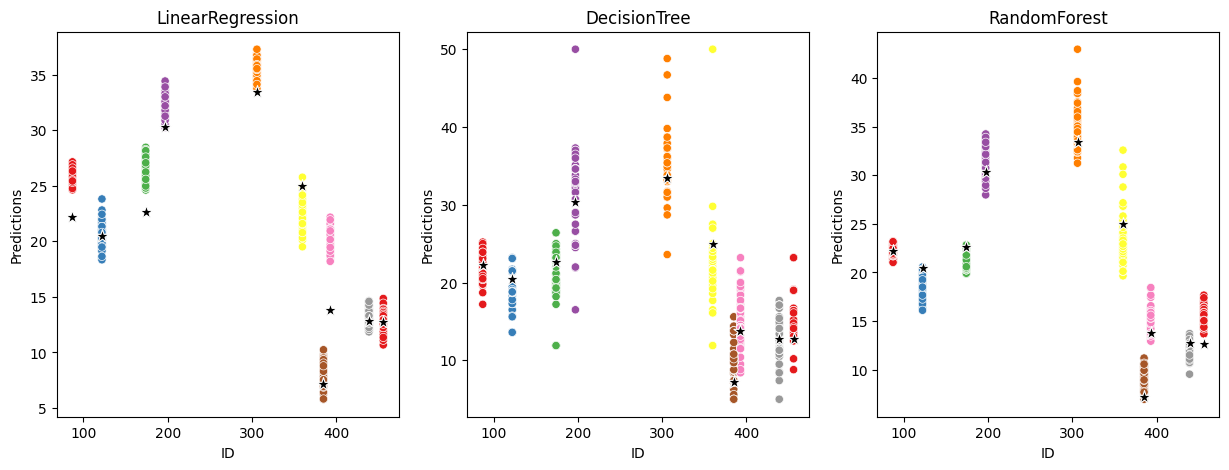

In [401]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
titles = ['LinearRegression', 'DecisionTree', 'RandomForest']

for i in range(3):

    plot_predictions(models[i], X, y, ax=ax[i], title=titles[i])

__7. (0.5 баллов)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 


> ## <div style='color:red'> Линейная регрессия </div>
>
> #### Как и было сказано ранее, модель линейной регрессии обладает низким разбросом. Все точки с предсказаниями на графике достаточно "сконцентрированы" и предсказания действительно имеют маленький разбор. Однако на некоторых объектах наблюдается достаточно большое смещение: истинное значение целевое значение для объекта (черная звездочка) может очень сильно отклоняться от среднего значения по предсказаниям. Предыдущие результаты по поводу большого смещения и низкого разброса подтвердились
>
> ## <div style='color:red'> Решающее дерево </div>
>
> #### Для данной модели видно, что разброс предсказаний действительно увеличился, но при этом их среднее значение стало действительно ближе к истинному значению для каждого объекта, Таким образом подтвердились предыдущие результаты, у решающего дерева большой разброс в предсказаниях и низкое смещение 
>
> ## <div style='color:red'> Случайный лес </div>
>
> ##### У случайного леса видны следующие результаты: средние значения предсказаний приблизительно совпадают со средними значениями предсказаний решающего дерева. Однако разброс самих предсказаний значительно уменьшился. Таким образом подтверждается суждение о том, что у случайного леса снижается разброс относительно базовой модели (решающего дерева), а смещение остается примерно на том же уровне

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [402]:
max_depths = np.arange(1, 11)
max_features = np.arange(1, X.shape[1])

bias_depth = []
bias_feats = []

var_depth = []
var_feats = []

for i in max_depths:

    forest = DecisionTreeRegressor(max_depth=i, random_state=52)

    _, variance, bias = compute_biase_variance(forest, X, y, num_runs=100)

    bias_depth.append(bias)
    var_depth.append(variance)

for j in max_features:

    forest = DecisionTreeRegressor(max_features=j, random_state=52)

    _, variance, bias = compute_biase_variance(forest, X, y, num_runs=100)

    bias_feats.append(bias)
    var_feats.append(variance)


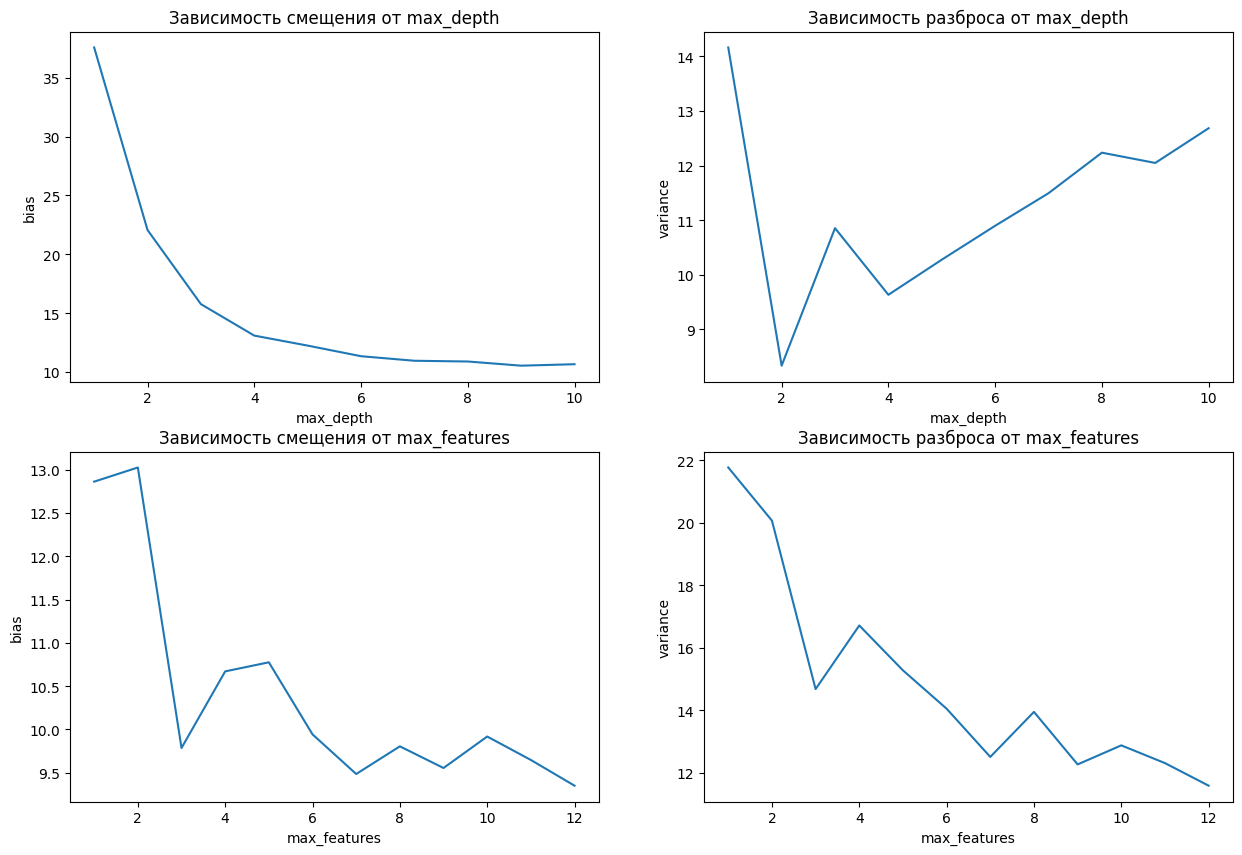

In [403]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0][0].plot(max_depths, bias_depth)
ax[0][0].set_xlabel('max_depth')
ax[0][0].set_ylabel('bias')
ax[0][0].set_title('Зависимость смещения от max_depth')

ax[0][1].plot(max_depths, var_depth)
ax[0][1].set_xlabel('max_depth')
ax[0][1].set_ylabel('variance')
ax[0][1].set_title('Зависимость разброса от max_depth')

ax[1][0].plot(max_features, bias_feats)
ax[1][0].set_xlabel('max_features')
ax[1][0].set_ylabel('bias')
ax[1][0].set_title('Зависимость смещения от max_features')

ax[1][1].plot(max_features, var_feats)
ax[1][1].set_xlabel('max_features')
ax[1][1].set_ylabel('variance')
ax[1][1].set_title('Зависимость разброса от max_features');

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [404]:
from sklearn.ensemble import GradientBoostingRegressor

estims = 2 ** np.arange(1,10)

bias_gb = []
bias_rf = []

var_gb = []
var_rf = []

for i in estims:

    gb = GradientBoostingRegressor(n_estimators=i, random_state=52)
    rf = RandomForestRegressor(n_estimators=i, random_state=52)

    _, variance_rf, bias_rfrst = compute_biase_variance(rf, X, y, num_runs=100)
    _, variance_gb, bias_gboost = compute_biase_variance(gb, X, y, num_runs=100)

    bias_gb.append(bias_gboost)
    bias_rf.append(bias_rfrst)

    var_gb.append(variance_gb)
    var_rf.append(variance_rf)


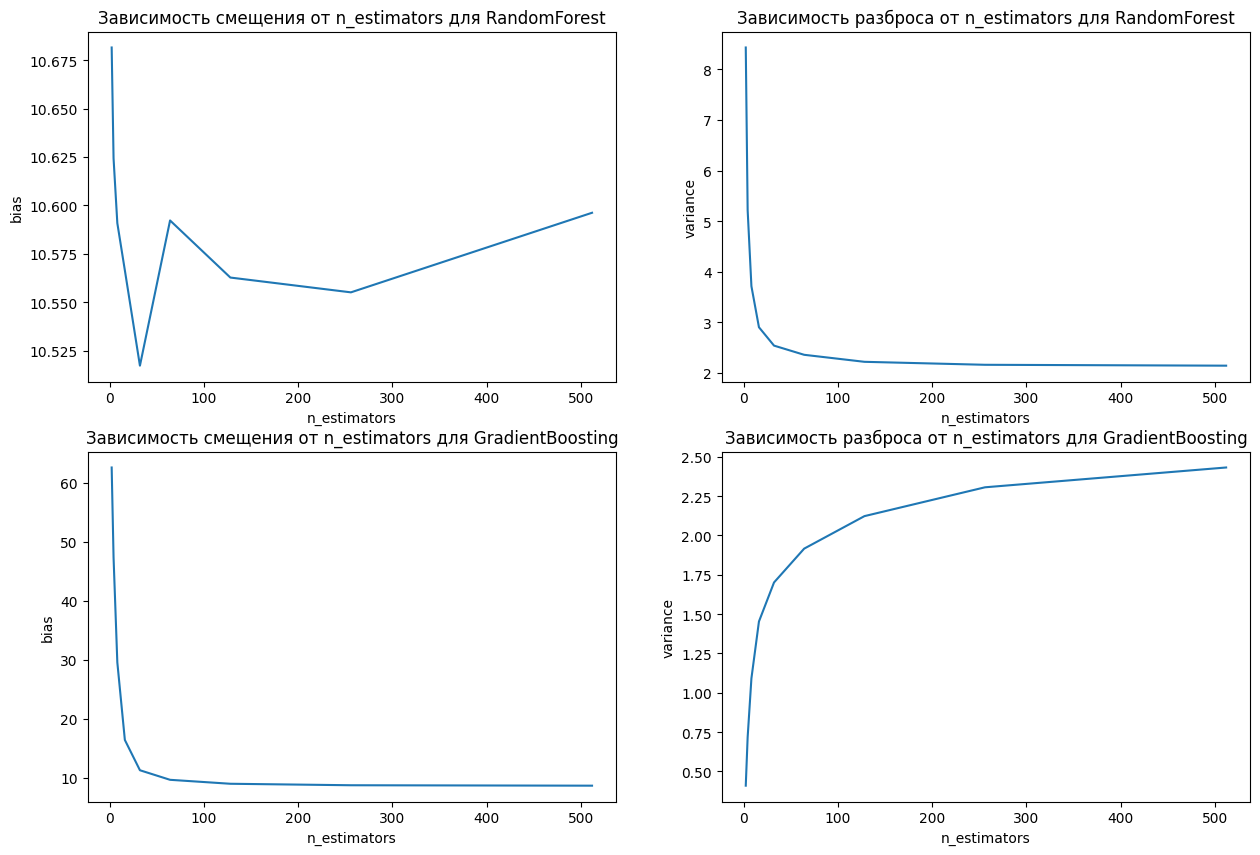

In [405]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0][0].plot(estims, bias_rf)
ax[0][0].set_xlabel('n_estimators')
ax[0][0].set_ylabel('bias')
ax[0][0].set_title('Зависимость смещения от n_estimators для RandomForest')

ax[0][1].plot(estims, var_rf)
ax[0][1].set_xlabel('n_estimators')
ax[0][1].set_ylabel('variance')
ax[0][1].set_title('Зависимость разброса от n_estimators для RandomForest')


ax[1][0].plot(estims, bias_gb)
ax[1][0].set_xlabel('n_estimators')
ax[1][0].set_ylabel('bias')
ax[1][0].set_title('Зависимость смещения от n_estimators для GradientBoosting')


ax[1][1].plot(estims, var_gb)
ax[1][1].set_xlabel('n_estimators')
ax[1][1].set_ylabel('variance')
ax[1][1].set_title('Зависимость разброса от n_estimators для GradientBoosting');

__10. (1.5 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.


> ### <div style='color:red'> Задание 8 </div>
>
> #### _**max_depth**_
> * #### **Смещение**
>   * #### С увеличением максимальной глубины дерево становится более переобученным и лучше подстраивается под данные. Так как дерево идеально подстраивается под данные, то и смещение уменьшается
>
> * #### **Разброс**
>
>   * #### Так как дерево становится более переобученным и больше подстраивается под данные, то оно и становится более чувствительным к изменениям входящих данных, а значит и разброс алгоритма должен увеличиваться 
>
> #### _**max_features**_
> * #### **Смещение**
>   * #### Так как увеличение параметра <code>max_features</code> помогает бороться с переобучением за счет того, что увеличивает максимальное количество признаков, по которым может происходить разбиение внутри дерева. Так как и признаков для разбиения становится больше, то и дерево становится более способным к выявлению нелинейных взаимосвязей, а следовательно и лучше выстраивая зависимости между признаками и целевой переменной, таким образом уменьшая смещение алгоритма
>
> * #### **Разброс**
>
>   * #### С увеличением параметра <code>max_features</code> дерево становится менее зависимым от обучающей выборки, так как имеются бОльшие возмоности для разбиения, а следовательно и разброс алгоритма уменьшается 
>


> ### <div style='color:red'> Задание 9 </div>
>
> #### _**Случайный лес**_
> * #### **Смещение**
>   * #### На графике видно, что дисперсия смещения для разного количества базовых алгоритмов крайне мала, что связано с тем, что смещение ансамбля соответствует смещению одного базового алгоритма
>
> * #### **Разброс**
>
>   * #### В силу тех же свойств беггинга, увеличение количества используемых базовых моделей уменьшает разброс ансамбля теоретически в $N$ раз. Однако в какой-то момент разброс выходит на асимптоту и разброс не сильно уменьшается, тк в какой-то момент возникают корреляции между признаками
>
> #### _**Градиентный бустинг**_
> * #### **Смещение**
>   * #### При увеличении количества базовых моделей ансамбль лучше подстраивается под данные уменьшая смещение ансамбля. С каждой новой моделью, обученной на ошибку предыдущей, ансамбль становится точнее 
>
> * #### **Разброс**
>
>   * #### На графике для разброса градиентного бустинга видно, что разница в разбросах между бустингом с 1 базовой моделью и 500 моделями небольшая. Это может быть связано с тем, что решающие деревья, использующиеся в градиентном бустинге, не очень глубокие (а значит и не слишком переобученные), а значит и менее чувствительны к изменениям обучающей выборки. Но так как глубина 3 у базовых моделей все-таки хоть и на некоторый скажем так $\epsilon$ чувствительна к изменениям обучающей выборки, то с увеличением количества базовых моделей разброс все-таки незначительно растет 



__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__